<h1><strong><u>Assignment 4</u></strong></h1>

In [ ]:
import matplotlib.pyplot as plt      
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer        
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

<h2><u>Data Loading and Preprocessing</u></h2>

In [2]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [3]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
X = data.drop("target", axis=1)
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457, 1)

(1115, 1)

(4457,)

(1115,)

In [5]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))



Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


<h2><u>Trivial Classifier Questions</u></h2>

<ol>
<li>Describe a trivial classifier that could achieve at least an accuracy of 0.8.</li>
<p>An example of a trivial classifier that could achieve a least an accuracy of 0.8 is the DummyClassifier class that is in SKLearn.</p></br>
<li>How would this classifier make its classification?</li>
<p>This classfier would make its predictions based on the class that appeared the most. In this case, it would predict 'ham' for all values.</p></br>
<li>What accuracy would it get on your training data?</li>
<p>The accuracy of that model on the training data would be over 80%.</p></br>
<li>In addition to accuracy, what metric should you use to ensure that your classifier is better than a trivial one?</li>
<p>Another metric besides accuracy that I can use to ensure that my classifier works better than a trivial one is recall and precision metrics. </p></br>
<li>What score would your trivial classifier get on this training data?</li>
<p>The score this model would receive for the recall score for 'ham' messages would be 1 and the recall score for 'spam' would be 0. The precision score for the 'ham' messages would be 0.8659 and the precision score for the 'spam' messages would be 0.</p></br>
</ol>

<h2><u>Selected Metrics</u></h2>

<div style="font-size: 14px">
<p>Metrics chosen(why?):
<ul>
<li>Accuracy - it provides a good idea of the overall performance of the classification </li>
<li>Precision - it shows how well the model did on putting positives correctly in the positive class (Controlling Type 1 Error)</li>
<li>Recall - it shows how well the model did on correctly not putting a positive in the negative class (Controlling Type 2 Error)</li>
</ul>
</p></br>
<p style=>Together, I believe that these three metrics will be good enough for the model evaluations. Even though, accuracy can be misleading especially when dealing with heavily skewed data like in this exercise, I believe precision and recall will help provide guidance through some of accuracy's possible pitfalls.</p>
<p style=>For this example, if given a classifier that always chooses 'ham' for its predictions instead of 'spam', the accuracy of that model would be over 80% for the training data that would be presented to it. On the other hand, for metrics such as precision and recall, the results would not be as good. Therefore, my baseline for those metrics would be an accuracy of at least 86%, a precision score of at least 86%, and a recall score for 'spam' better than 0.</p>
</div>

<h2><strong><u>Bayesian Model</u></strong><h2>

<h3><u>Count Vectorization</u></h3>

In [7]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

In [ ]:
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

In [ ]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("clf", None)
    ]
)
param_grid = [
    {"clf": [ComplementNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [MultinomialNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [GaussianNB()]},
    {"clf": [CategoricalNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [BernoulliNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]}
    ]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_
print(nb_model)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


KeyboardInterrupt: 

<h3><u>Bayesian Training Results<u></h3>

In [14]:
metrics = {'Accuracy': 'accuracy', 'Precision (Macro)': 'precision_macro', 'Recall (Macro)': 'recall_macro'}

In [ ]:
#Cross-Validation Loop

for key, value in metrics.items():
    bayesian_training_values = cross_val_score(nb_model, X_train, y_train, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", bayesian_training_values)
    np_bayesian_training_values = np.array(bayesian_training_values)
    average = np.mean(np_bayesian_training_values)
    stDev = np.std(np_bayesian_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 653, in fit
    routed_params = self._check_method_params(method="fit", props=params)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 459, in _check_method_params
    raise ValueError(
    ...<5 lines>...
    )
ValueError: Pipeline.fit does not accept the clf parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.


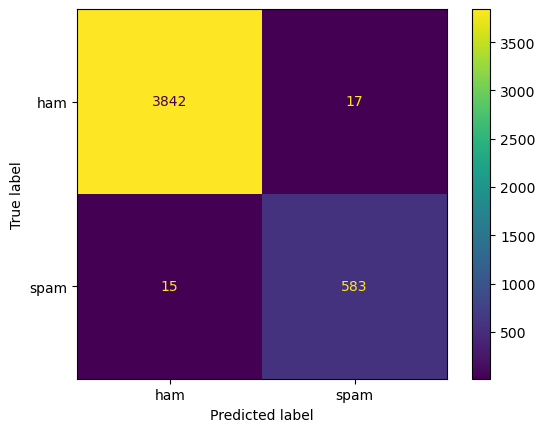

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_train, y_train)

<h3><u>Bayesian Testing Results</u></h3>

In [ ]:
nb_test_predictions = nb_model.predict(X_test)

nb_test_accuracy = accuracy_score(y_test, nb_test_predictions)
print("Naive Bayes Test Accuracy: {:.2f}%".format(nb_test_accuracy * 100))

nb_test_precision = precision_score(y_test, nb_test_predictions, average='macro')
print("Naive Bayes Test Precision: {:.2f}%".format(nb_test_precision * 100))

nb_test_recall = recall_score(y_test, nb_test_predictions, average='macro')
print("Naive Bayes Test Recall: {:.2f}%".format(nb_test_recall * 100))


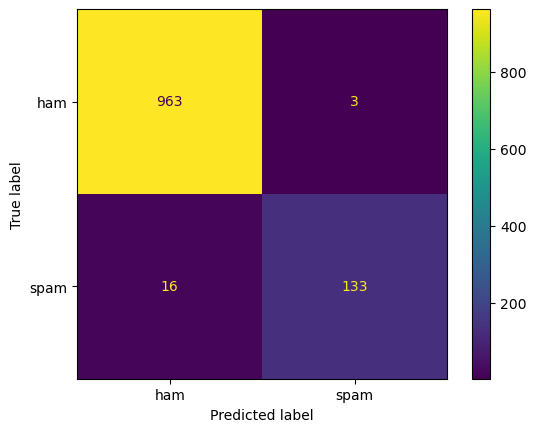

In [ ]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, nb_test_predictions)

<ol>
<li>Did your classifier perform better than one that always predicted "ham"?</li>
<p>Yes, my model did perform better than one that always predicts "ham".</p></br>
<li>Were your testing metrics within the "bounds" set by your train/validation split (mean +/- std dev)?</li>
<p>Yes, from the results stated above, I do believe that my testing metrics were within the "bounds" set by my train/validation split.</p></br>
<li>Would you use this "bare" classifier as a filter on your own messages?</li>
<p>No, because I would like to see how it would score if given more data especially more 'spam' examples since the data was mostly 'ham' messages.</p></br>
</ol>

<h3><u>Bayesian Training Learning Curves</u><h3>

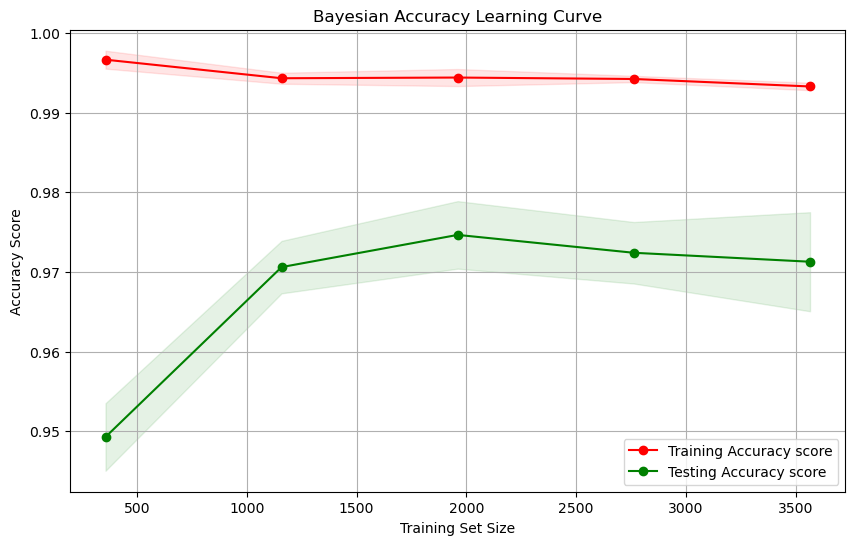

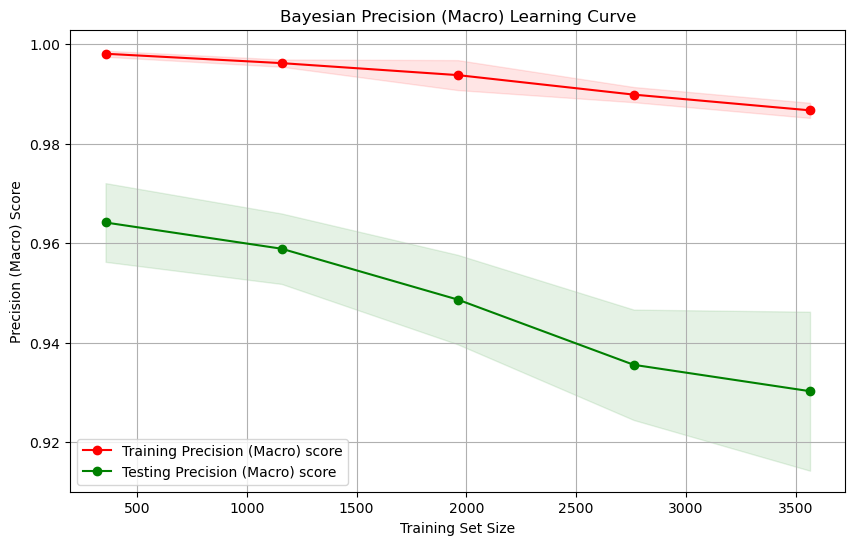

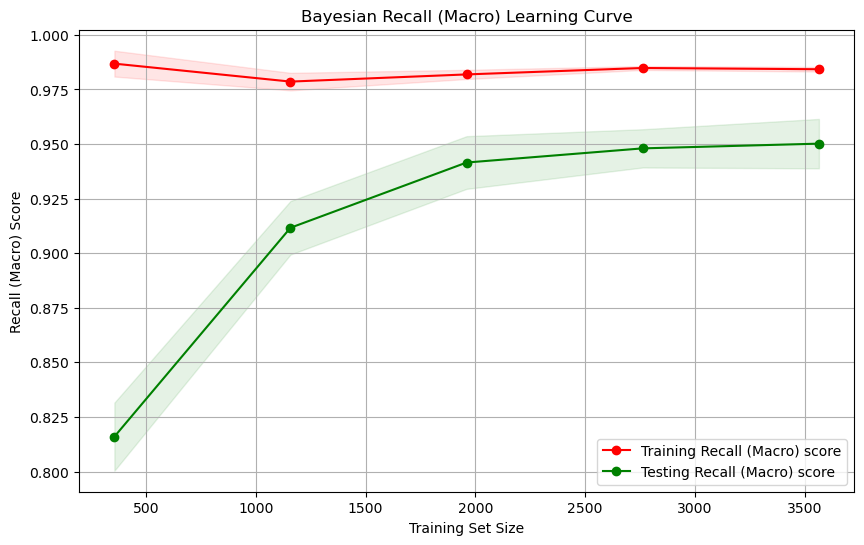

In [ ]:
for key, value in metrics.items():
    bayesian_train_sizes, bayesian_train_scores, bayesian_test_scores = learning_curve(
        nb_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_test_scores_mean = np.mean(bayesian_test_scores, axis=1)
    bayesian_test_scores_std = np.std(bayesian_test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_test_scores_mean - bayesian_test_scores_std,
                    bayesian_test_scores_mean + bayesian_test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
             label=f"Training {key} score")
    plt.plot(bayesian_train_sizes, bayesian_test_scores_mean, 'o-', color="g",
             label=f"Testing {key} score")

    plt.legend(loc="best")
    plt.show()

<ol>
<li>Describe what this learning curve is telling you about how your algorithm might perform if given more data.</li>
<p>After analyzing the learning curves from above, I can conclude that my Bayesian model does not perform better when given more data especially in terms of the 'Precision' metric. Precision is the model's ability to correctly identify positives as positives. Therefore, precision is one of the most crucial metrics in determining the fit of a classification model. Since this model does an insufficient job at 'precision' as more training data is added, I would strongly consider researching another classfication model for this dataset.</p></br>

<li>That is, does it appear to still be learning even as you get to larger input sizes?</li>
<p>I do not believe that the Bayesian model is not capturing the logic of the data completely.</p></br>

<li>If you built an App to classify spam SMS messages, would that App be able to learn/improve from your user's classification of messages?</li>
<p>In my honest opinion, I wouldn't use this as a model for an SMS spam classifier app mainly because of the precision issue that I stated earlier. The ability of my model to be correct when the value is actually not positive is one of the most crucial elements that the model needs to perform well on. So, I would most likely use another model.</p></br>
</ol>

<h2><strong><u>TFIDF Vectorization and Logistic Classifier Model</u></strong></h2>

<h3><u>Pipeline Cross-Validation Model Selection</u></h3>

In [ ]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", LogisticRegression())
    ]
)
param_grid = {
    "clf__penalty": ['l1', 'l2'], 
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "vect__use_idf": [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
log_model = grid_search.best_estimator_
print(log_model)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimato

{'clf__C': 500, 'clf__penalty': 'l2', 'vect__use_idf': True}

<h3><u>TFIDF Vectorization and Logistic Classifier Training Results</u></h3>

In [ ]:
for key, value in metrics.items():
    logistic_training_values = cross_val_score(log_model, X_train, y_train, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", logistic_training_values)
    np_logistic_training_values = np.array(logistic_training_values)
    average = np.mean(np_logistic_training_values)
    stDev = np.std(np_logistic_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.98206278 0.9809417  0.97306397 0.97194164 0.97643098]
0.98  +/-  0.0041 

Cross-validation Precision (Macro) training scores:  [0.98181217 0.97365932 0.97609355 0.97109355 0.97815552]
0.98  +/-  0.0037 

Cross-validation Recall (Macro) training scores:  [0.94037133 0.94324266 0.90703632 0.90562002 0.91887273]
0.92  +/-  0.016 



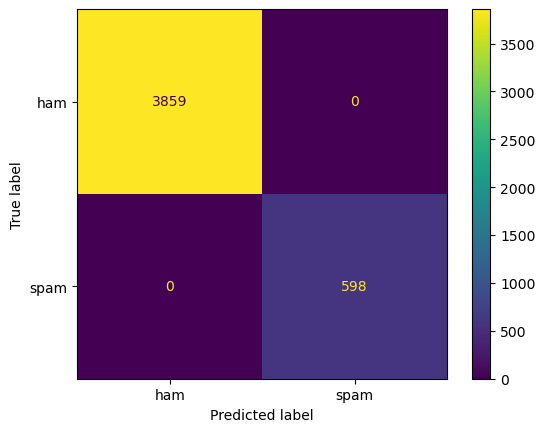

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_model, X_train, y_train)

<h3><u>TFIDF Vectorization and Logistic Classifier Testing Results</u></h3>

In [ ]:
log_test_predictions = log_model.predict(X_test)

log_test_accuracy = accuracy_score(y_test, log_test_predictions)
print("Naive Bayes Test Accuracy: {:.2f}%".format(log_test_accuracy * 100))

log_test_precision = precision_score(y_test, log_test_predictions, average='macro')
print("Naive Bayes Test Precision: {:.2f}%".format(log_test_precision * 100))

log_test_recall = recall_score(y_test, log_test_predictions, average='macro')
print("Naive Bayes Test Recall: {:.2f}%".format(log_test_recall * 100))


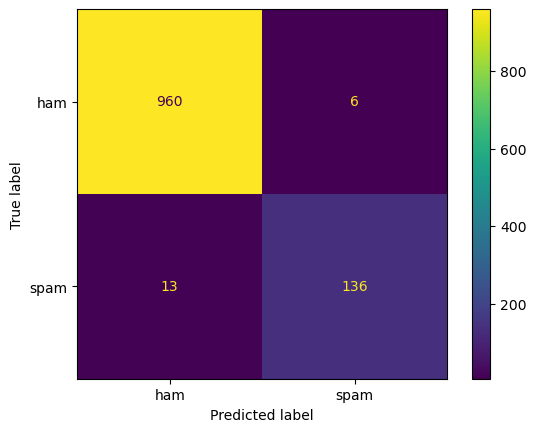

In [ ]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, log_test_predictions)

<ol>
<li>Did your classifier perform better than one that always predicted "ham"?</li>
<p>Yes, my model did perform better than one that always predicts "ham".</p></br>
<li>Were your testing metrics within the "bounds" set by your train/validation split (mean +/- std dev)?</li>
<p>Yes, my testing metrics were within the "bounds" set by my train/validation split.</p></br>
<li>Would you use this "bare" classifier as a filter on your own messages?</li>
<p>No because I would like to see how it would score if given more data especially more 'spam' examples since the data was mostly 'ham' messages.</p></br>
</ol>

<h3><u>TFIDF Vectorization and Logistic Classifier Training Learning Curves</u></h3>

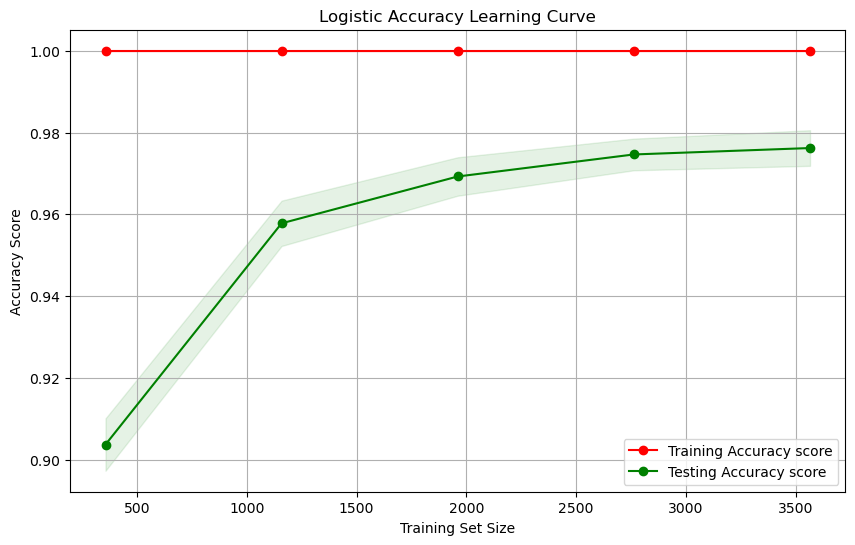

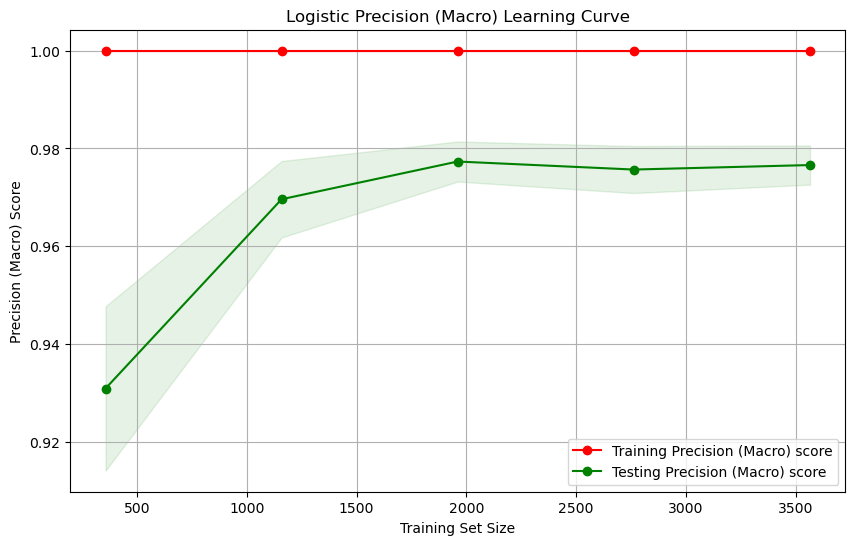

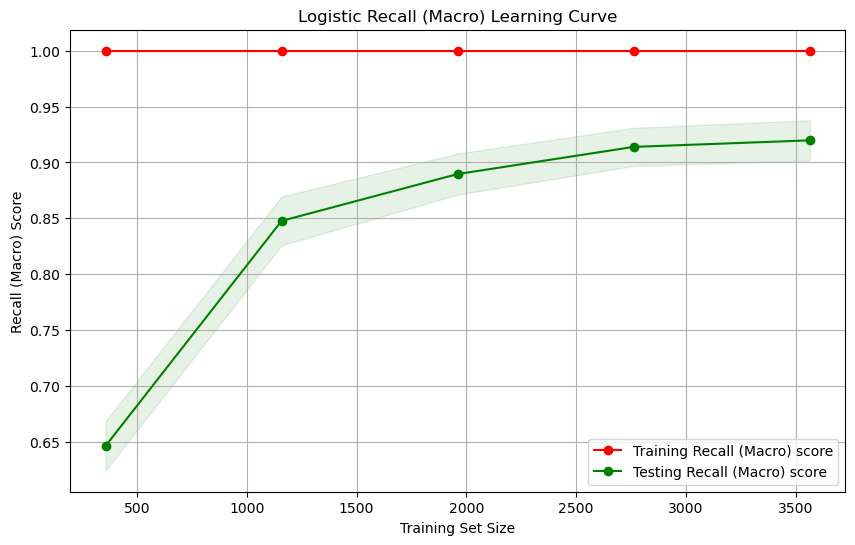

In [ ]:
for key, value in metrics.items():
    logistic_train_sizes, logistic_train_scores, logistic_test_scores = learning_curve(
        log_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
    logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
    logistic_test_scores_mean = np.mean(logistic_test_scores, axis=1)
    logistic_test_scores_std = np.std(logistic_test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Logistic {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(logistic_train_sizes, logistic_train_scores_mean - logistic_train_scores_std,
                    logistic_train_scores_mean + logistic_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(logistic_train_sizes, logistic_test_scores_mean - logistic_test_scores_std,
                    logistic_test_scores_mean + logistic_test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(logistic_train_sizes, logistic_train_scores_mean, 'o-', color="r",
             label=f"Training {key} score")
    plt.plot(logistic_train_sizes, logistic_test_scores_mean, 'o-', color="g",
             label=f"Testing {key} score")

    plt.legend(loc="best")
    plt.show()

<ol>
<li>Describe what this learning curve is telling you about how your algorithm might perform if given more data.</li>
<p>After analyzing the learning curves for the Logistic model, it can be seen that all of the curves are positive. This means that the model does a good job at correcting 'False Negatives' and correcting 'False Positives'. Therefore, I can say that the model will perform well when given more data.</p></br>
<li>That is, does it appear to still be learning even as you get to larger input sizes?</li>
<p>Yes, the positive learning curves from the logistic model lead to believe that the model is learning as it is receives larger input sizes.</p></br>
<li>If you built an App to classify spam SMS messages, would that App be able to learn/improve from your user's classification of messages?</li>
<p>Honestly, I would consider making it into an app especially since the learning curve from all of the metrics were positive.</p></br>
</ol>

<h2><u>Conclusions</u></h2>

<p style="font-size: 16px">From gathering results for both Bayesian and Logistic Models, I can conclude that, even though both models performed better than the baselines, the Logistic model performed better on the data than the Bayesian model did. The Bayesian model had a positive learning curve on all of the metrics except for recall. On the other hand, the Logistic model had a positive learning curve on all of the metrics that were scored. Therefore, I would choose to use the logistic model instead of the bayesian model to solve these types of problems. Lastly, I believe that adding labeled data would mainly improve the Logistic model because it has positive learning curves for all of the metrics tested.</p>
